In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cibmtr-metric/cibmtr_metric.py
/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv
/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv
/kaggle/input/equity-post-HCT-survival-predictions/train.csv
/kaggle/input/equity-post-HCT-survival-predictions/test.csv
/kaggle/input/pip-install-lifelines/fonttools-4.55.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/pip-install-lifelines/tzdata-2024.2-py2.py3-none-any.whl
/kaggle/input/pip-install-lifelines/kiwisolver-1.4.7-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
/kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
/kaggle/input/pip-install-lifelines/scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/pip-install-lifelines/pillow-11.0.0-cp310-cp310-manylinux_2_28_x86_64.whl
/kaggle/input/pip-install-lifelines/contourpy-1.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/

In [4]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=bbef3b1f627660c055c7f7dfb81e3fc25722edd54f22565dcded576a9c80e9bf
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from metric import score
from scipy.sparse import issparse
import warnings
warnings.filterwarnings('ignore')

In [6]:
data_dictionary = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv')
train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
submission = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv')


In [7]:
def transform_dataset(df,numerical_features,categorical_features,test_data=True):# Create transformers for numeric and categorical columns
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values in numeric columns
        ('scaler', StandardScaler())  # Standardize the numeric features
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values in categorical columns
        ('onehot', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncoding for categorical features
    ])
    
    # Create a column transformer to apply the transformations
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    import pickle
    if test_data:
        # Fit the preprocessing pipeline on training data
        df_processed = preprocessor.fit_transform(df)
        import pickle
        with open('preprocessor.pkl', 'wb') as f:
            pickle.dump(preprocessor, f)
    else:
        with open('preprocessor.pkl', 'rb') as f:
            preprocessor = pickle.load(f)
        df_processed = preprocessor.transform(df)
    # Check if X_train_processed is a sparse matrix
    if issparse(df_processed):
        print("df_processed is a sparse matrix.")
        print(f"Shape of sparse matrix: {df_processed.shape}")
        # Convert sparse matrix to a dense numpy array
        df_processed = df_processed.toarray()
        print("Converted sparse matrix to dense array.")
    else:
        print("X_train_processed is already dense.")
        print(f"Shape of dense matrix: {df_processed.shape}")
    
    # After preprocessing, handle column names properly
    numeric_column_names = numerical_features
    
    # For categorical columns, the one-hot encoder will generate new column names
    ohe_columns = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
    print(f"Number of columns created by OneHotEncoder: {len(ohe_columns)}")
    
    # Combine the column names for the numeric and categorical features
    all_column_names = numeric_column_names + ohe_columns.tolist()
    print(f"Length of all_column_names: {len(all_column_names)}")
    print(f"Shape of X_train_processed: {df_processed.shape[1]}")
    
    # Now create the DataFrame with proper column names
    try:
        df_final = pd.DataFrame(df_processed, columns=all_column_names)
        print("DataFrame created successfully.")
    except ValueError as e:
        print(f"Error when creating DataFrame: {e}")
    
    # Check for NaN or Infinite values
    print("Checking for NaN values in df_final:")
    print(df_final.isnull().sum())
    
    # Replace any NaN or Infinite values with appropriate imputation strategy
    df_final = df_final.fillna(df_final.mean())  # Impute NaNs with mean
    
    # Replace infinite values with large finite values (or NaN) and impute them
    df_final.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_final = df_final.fillna(df_final.mean())  # Impute NaNs again
    # Replace all non-alphanumeric characters (except space) with underscores
    df_final.columns = df_final.columns.str.replace(r'\s+', '_', regex=True)
    df_final.columns = df_final.columns.str.replace(r'[^\w\s]', '_', regex=True)
    from collections import Counter
    
    def make_unique(columns):
        counts = Counter()
        unique_columns = []
        
        for col in columns:
            counts[col] += 1
            if counts[col] > 1:
                # Append a counter to make duplicate columns unique
                unique_columns.append(f"{col}_{counts[col] - 1}")
            else:
                unique_columns.append(col)
        
        return unique_columns
    
    # Apply the make_unique function to both training and testing data columns
    df_final.columns = make_unique(df_final.columns.tolist())
    return df_final

In [8]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from metric import score  # Assuming 'score' is a custom function for the c-index calculation

# Define the useful columns and target features
useful_features = [col for col in train.columns if col not in ['ID', 'efs', 'efs_time','year_hct']]
target_features = ['efs', 'efs_time']

# Separate numeric and categorical columns
num_col = [col for col in useful_features if train[col].dtype != 'object']
cat_col = [col for col in useful_features if col not in num_col]

# Preprocessing the dataset
train_processed = transform_dataset(train[useful_features], num_col, cat_col)

# Prepare the data (X for features, y for target)
X = train_processed
y = train[target_features]

# KFold Cross-validation
kf = KFold(n_splits=5, shuffle=False)

# List to keep track of metrics
c_index_scores = []
best_models = []

# Loop over each fold
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}:")
    
    # Splitting data into train and test sets for each fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Extract the 'ID' column from the original dataframe
    X_train['ID'] = train.iloc[train_index]['ID']
    X_test['ID'] = train.iloc[test_index]['ID']
    
    # Initialize the CatBoost model
    cat_model = CatBoostRegressor(
        loss_function="Cox",
        iterations=1000,  # Start with fewer iterations for testing
        learning_rate=0.05,  # Lower learning rate
        depth=8,  # Slightly deeper trees
        random_seed=42,
        l2_leaf_reg=3,  # Regularization to prevent overfitting
        subsample=0.7,  # Subsampling to reduce overfitting
        colsample_bylevel=0.8,  # Feature sampling per level
        early_stopping_rounds=50  # Early stopping to prevent overfitting
    )
    
    # Train the model
    cat_model.fit(X_train.drop(columns='ID'), y_train['efs_time'], 
                  eval_set=(X_test.drop(columns='ID'), y_test['efs_time']), 
                  verbose=0)
    
    # Get the best iteration (best model based on validation score)
    best_iteration = cat_model.get_best_iteration()
    print(f"Best iteration for fold {i}: {best_iteration}")
    
    # Save the best model for this fold
    best_models.append(cat_model)
    
    # Make predictions using the best iteration
    risk_scores_cat = cat_model.predict(X_test.drop(columns='ID'))
    
    # Prepare y_true and y_pred for scoring
    y_true = X_test[["ID"]].copy()  # Start with ID column from X_test
    y_true['race_group'] = train.iloc[test_index]['race_group'].values
    y_true = y_true.merge(y_test[['efs', 'efs_time']], left_index=True, right_index=True)
    
    # Prepare y_pred with ID and predictions
    y_pred = X_test[["ID"]].copy()  # Include 'ID'
    y_pred["prediction"] = risk_scores_cat  # Add predictions as a new column

    # Call the scoring function with row_id_column_name
    m = score(y_true, y_pred, row_id_column_name="ID")
    
    # Print the C-index score for this fold
    print(f"C-index for CatBoost (Fold {i}) = {m}")
    
    # Append C-index score for comparison
    c_index_scores.append(m)

# After all folds, select the best model based on the highest C-index
best_fold_idx = np.argmax(c_index_scores)
best_model_cat = best_models[best_fold_idx]
print(f"Best model is from fold {best_fold_idx} with C-index = {c_index_scores[best_fold_idx]}")


X_train_processed is already dense.
Shape of dense matrix: (28800, 182)
Number of columns created by OneHotEncoder: 161
Length of all_column_names: 182
Shape of X_train_processed: 182
DataFrame created successfully.
Checking for NaN values in df_final:
hla_match_c_high          0
hla_high_res_8            0
hla_low_res_6             0
hla_high_res_6            0
hla_high_res_10           0
                         ..
cardiac_Not done          0
cardiac_Yes               0
pulm_moderate_No          0
pulm_moderate_Not done    0
pulm_moderate_Yes         0
Length: 182, dtype: int64
Fold 0:
Best iteration for fold 0: 281
C-index for CatBoost (Fold 0) = 0.6397219342275586
Fold 1:
Best iteration for fold 1: 298
C-index for CatBoost (Fold 1) = 0.6405860605025563
Fold 2:
Best iteration for fold 2: 356
C-index for CatBoost (Fold 2) = 0.6432577999398507
Fold 3:
Best iteration for fold 3: 303
C-index for CatBoost (Fold 3) = 0.6366989313677639
Fold 4:
Best iteration for fold 4: 204
C-index for Ca

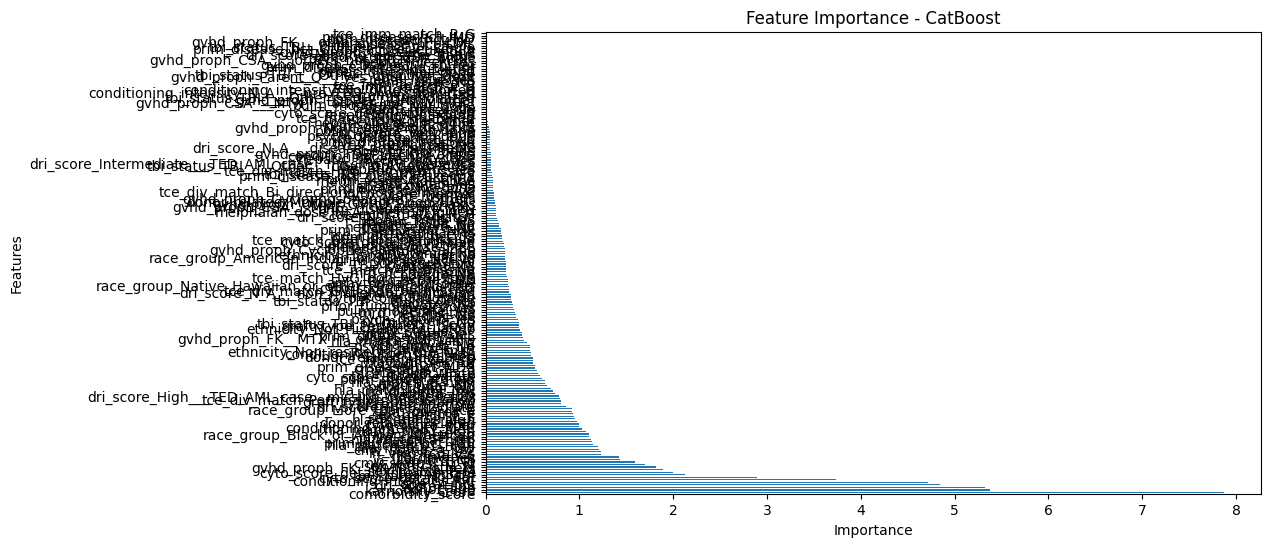

In [24]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = best_model_cat.get_feature_importance()

# Ensure you're excluding the 'ID' column
features = X_train.drop(columns='ID').columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'features': features,
    'importance': feature_importance
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance_df.plot(kind='barh', x='features', y='importance', legend=False, ax=plt.gca())
plt.title("Feature Importance - CatBoost")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


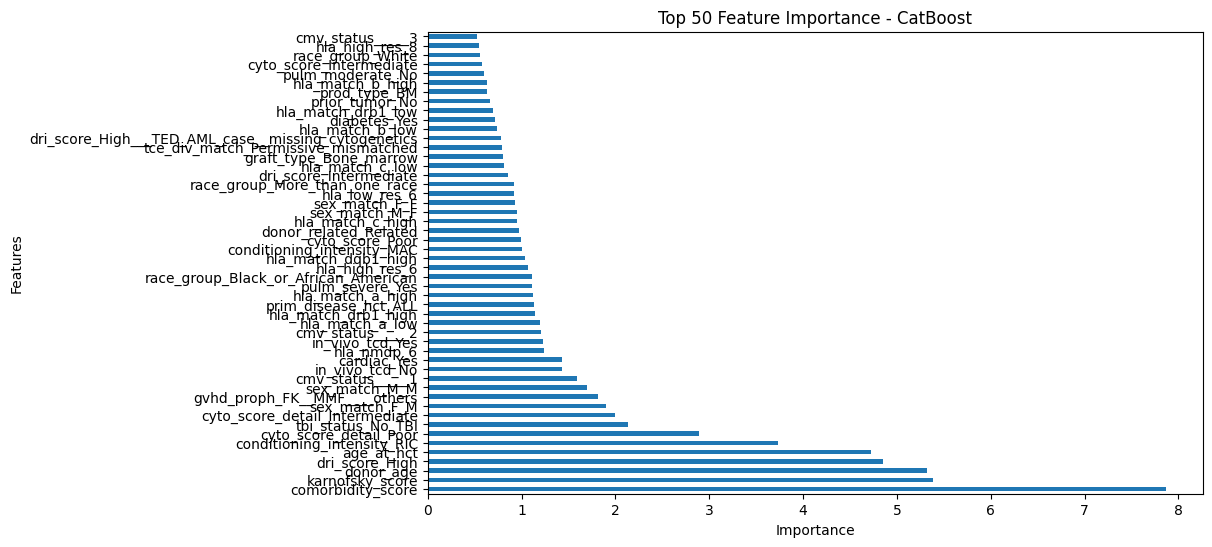

In [26]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = best_model_cat.get_feature_importance()

# Ensure you're excluding the 'ID' column
features = X_train.drop(columns='ID').columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'features': features,
    'importance': feature_importance
})

# Sort the DataFrame by importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Select the top 50 features
top_50_features = feature_importance_df.head(50)

# Plot the top 50 feature importances
plt.figure(figsize=(10, 6))
top_50_features.plot(kind='barh', x='features', y='importance', legend=False, ax=plt.gca())
plt.title("Top 50 Feature Importance - CatBoost")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


In [10]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np
from metric import score  # Assuming 'score' is a custom function for the c-index calculation

# Define the useful columns and target features
useful_features = [col for col in train.columns if col not in ['ID', 'efs', 'efs_time','year_hct']]
target_features = ['efs', 'efs_time']

# Separate numeric and categorical columns
num_col = [col for col in useful_features if train[col].dtype != 'object']
cat_col = [col for col in useful_features if col not in num_col]

# Preprocessing the dataset
train_processed = transform_dataset(train[useful_features], num_col, cat_col)

# Prepare the data (X for features, y for target)
X = train_processed
y = train[target_features]

# KFold Cross-validation
kf = KFold(n_splits=5, shuffle=False)

# List to keep track of metrics
c_index_scores = []
best_models = []

# Loop over each fold
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}:")
    
    # Splitting data into train and test sets for each fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Extract the 'ID' column from the original dataframe
    X_train['ID'] = train.iloc[train_index]['ID']
    X_test['ID'] = train.iloc[test_index]['ID']
    
    # Initialize the XGBoost model for survival analysis
    xgb_model = XGBRegressor(
        objective='survival:cox',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    
    # Train the model
    xgb_model.fit(
        X_train.drop(columns='ID'),
        y_train['efs_time'],
        eval_set=[(X_test.drop(columns='ID'), y_test['efs_time'])],
        eval_metric="cox-nloglik",
        early_stopping_rounds=10,
        verbose=0
    )
    
    # Get the best iteration
    best_iteration = xgb_model.best_iteration
    print(f"Best iteration for fold {i}: {best_iteration}")
    
    # Save the best model for this fold
    best_models.append(xgb_model)
    
    # Make predictions using the model
    risk_scores_cat = xgb_model.predict(X_test.drop(columns='ID'))
    
    # Prepare y_true and y_pred for scoring
    y_true = X_test[["ID"]].copy()  # Start with ID column from X_test
    y_true['race_group'] = train.iloc[test_index]['race_group'].values
    y_true = y_true.merge(y_test[['efs', 'efs_time']], left_index=True, right_index=True)
    
    # Prepare y_pred with ID and predictions
    y_pred = X_test[["ID"]].copy()  # Include 'ID'
    y_pred["prediction"] = risk_scores_cat  # Add predictions as a new column

    # Call the scoring function with row_id_column_name
    m = score(y_true, y_pred, row_id_column_name="ID")
    
    # Print the C-index score for this fold
    print(f"C-index for XGBoost (Fold {i}) = {m}")
    
    # Append C-index score for comparison
    c_index_scores.append(m)

# After all folds, select the best model based on the highest C-index
best_fold_idx = np.argmax(c_index_scores)
best_model_xgb = best_models[best_fold_idx]
print(f"Best model is from fold {best_fold_idx} with C-index = {c_index_scores[best_fold_idx]}")


X_train_processed is already dense.
Shape of dense matrix: (28800, 182)
Number of columns created by OneHotEncoder: 161
Length of all_column_names: 182
Shape of X_train_processed: 182
DataFrame created successfully.
Checking for NaN values in df_final:
hla_match_c_high          0
hla_high_res_8            0
hla_low_res_6             0
hla_high_res_6            0
hla_high_res_10           0
                         ..
cardiac_Not done          0
cardiac_Yes               0
pulm_moderate_No          0
pulm_moderate_Not done    0
pulm_moderate_Yes         0
Length: 182, dtype: int64
Fold 0:
Best iteration for fold 0: 99
C-index for XGBoost (Fold 0) = 0.6355940074841616
Fold 1:
Best iteration for fold 1: 99
C-index for XGBoost (Fold 1) = 0.6356938534524619
Fold 2:
Best iteration for fold 2: 93
C-index for XGBoost (Fold 2) = 0.6359435700419532
Fold 3:
Best iteration for fold 3: 99
C-index for XGBoost (Fold 3) = 0.6338956701411768
Fold 4:
Best iteration for fold 4: 99
C-index for XGBoost (Fo

In [11]:

test_processed = transform_dataset(test[useful_features], num_col, cat_col,test_data=False)

test_processed.head()

X_train_processed is already dense.
Shape of dense matrix: (3, 182)
Number of columns created by OneHotEncoder: 161
Length of all_column_names: 182
Shape of X_train_processed: 182
DataFrame created successfully.
Checking for NaN values in df_final:
hla_match_c_high          0
hla_high_res_8            0
hla_low_res_6             0
hla_high_res_6            0
hla_high_res_10           0
                         ..
cardiac_Not done          0
cardiac_Yes               0
pulm_moderate_No          0
pulm_moderate_Not done    0
pulm_moderate_Yes         0
Length: 182, dtype: int64


,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,...,donor_related_Related,donor_related_Unrelated,melphalan_dose_MEL,melphalan_dose_N_A__Mel_not_given,cardiac_No,cardiac_Not_done,cardiac_Yes,pulm_moderate_No,pulm_moderate_Not_done,pulm_moderate_Yes
0,-5.610384e-16,-6.357585e-16,0.753386,0.811944,1.075758e-15,0.649272,0.755021,0.585379,0.661997,0.572963,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,5.949953e-01,8.039862e-01,0.753386,0.811944,8.374026e-01,0.649272,0.755021,0.585379,0.661997,0.572963,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,5.949953e-01,8.039862e-01,0.753386,0.811944,8.374026e-01,0.649272,0.755021,0.585379,0.661997,0.572963,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [12]:
risk_scores_xgb_test = best_model_xgb.predict(test_processed)
risk_scores_cat_test = best_model_cat.predict(test_processed)
combined_test = 0.5 * risk_scores_xgb_test + 0.5 * risk_scores_cat_test

In [13]:
# Prepare the submission DataFrame
submission = pd.DataFrame({
    'ID': test['ID'],  
    'prediction': combined_test
})

In [14]:
submission

,ID,prediction
0,28800,0.085966
1,28801,0.572374
2,28802,0.123983


In [15]:
# Save the submission file in CSV format
submission.to_csv('submission.csv', index=False)